<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20241214%5D%20Hybrid%20of%20LR-Bi-LSTM%20for%205%20class%20with%20FGSM%20on%20WSN-DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid LR-Bi-LSTM for 10 class classifications based on UNSW-NB15 dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [2]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values
#X = dataset.drop(['Class'], axis=1)
#y = dataset['Class']

In [3]:
dataset

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,0
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,0
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,0
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,0
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,0
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,0
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,0
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,0


### **Data Preprocessing**

In [4]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [5]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [340066  14596  10049   6638   3312]


In [6]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00


In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the data
#smote = SMOTE(random_state=42)
#X_balanced, y_balanced = smote.fit_resample(X, y)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [340066 340066 340066 340066 340066]


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **Hybrid combination of LR-Bi-LSTM for 10 class classifications on UNSW-NB15**

LR model Standalone

In [ ]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred))

Hybrid model with using features results from LR model as Bi-LSTM input

In [10]:
from keras.utils import to_categorical

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Extract probabilities from LR model
train_lr_features = lr_model.predict_proba(X_train)  # Features for Bi-LSTM from training data
test_lr_features = lr_model.predict_proba(X_test)    # Features for Bi-LSTM from test data

# Reshape LR features for Bi-LSTM input
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# Convert labels to one-hot encoding for Bi-LSTM
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
## Build the Bi-LSTM model

#bilstm_model = Sequential()
#bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, train_lr_features.shape[2])))
#bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Bidirectional(LSTM(32)))
#bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Dense(10, activation='softmax'))  # 10 classes

#bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.regularizers import l2

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))))
bilstm_model.add(Dropout(0.2))
#bilstm_model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.0001)))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Bi-LSTM model
history = bilstm_model.fit(train_lr_features, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1)

# Evaluate the hybrid model on the test set
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 361s 8ms/step - accuracy: 0.9981 - loss: 0.0638 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 2/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 379s 8ms/step - accuracy: 0.9999 - loss: 0.0145 - val_accuracy: 0.9999 - val_loss: 0.0140
Epoch 3/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 346s 8ms/step - accuracy: 0.9999 - loss: 0.0143 - val_accuracy: 0.9999 - val_loss: 0.0142
Epoch 4/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 374s 8ms/step - accuracy: 0.9999 - loss: 0.0144 - val_accuracy: 0.9998 - val_loss: 0.0142
Epoch 5/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 387s 8ms/step - accuracy: 0.9999 - loss: 0.0144 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 6/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 383s 8ms/step - accuracy: 0.9999 - loss: 0.0143 - val_accuracy: 0.9999 - val_loss: 0.0148
Epoch 7/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 399s 9ms/step - accuracy: 0.9999 - loss: 0.0143 - val_accuracy: 0.9999 - val_loss: 0.0141
Epoch 8/20
40928/40928 ━━━━━━━━━━━━━━━━━━━━ 380s 9ms/step - ac

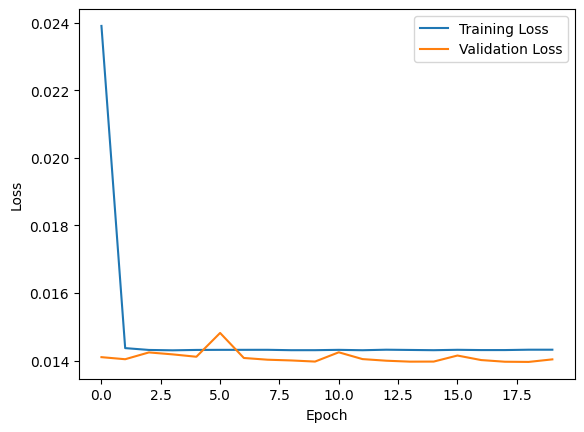

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)


Hybrid Model Accuracy: 0.9998924940047083

Precision: 0.9998925166019903

Recall: 0.9998924940047083

F1-Score: 0.999892494869149


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90951
           1       1.00      1.00      1.00     90951
           2       1.00      1.00      1.00     90951
           3       1.00      1.00      1.00     90951
           4       1.00      1.00      1.00     90951
           5       1.00      1.00      1.00     90951
           6       1.00      1.00      1.00     90951
           7       1.00      1.00      1.00     90951
           8       1.00      1.00      1.00     90951

    accuracy                           1.00    818559
   macro avg       1.00      1.00      1.00    818559
weighted avg       1.00      1.00      1.00    818559



In [ ]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.10f}")

Detection Rate for Class 0: 1.0000000000
Detection Rate for Class 1: 1.0000000000
Detection Rate for Class 2: 0.9999340304
Detection Rate for Class 3: 0.9996151774
Detection Rate for Class 4: 0.9998350760
Detection Rate for Class 5: 0.9998900507
Detection Rate for Class 6: 1.0000000000
Detection Rate for Class 7: 0.9997581115
Detection Rate for Class 8: 1.0000000000


**With FGSM adversarial training**

In [11]:
import tensorflow as tf
from keras.regularizers import l2

#Build the Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))))
bilstm_model.add(Dropout(0.2))
#bilstm_model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.0001)))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# FGSM: Function to generate adversarial examples
def generate_adversarial_examples(model, data, labels, epsilon=0.1):
    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(data_tensor)
        predictions = model(data_tensor)
        loss = tf.keras.losses.categorical_crossentropy(labels_tensor, predictions)

    gradients = tape.gradient(loss, data_tensor)
    perturbations = epsilon * tf.sign(gradients)
    adversarial_data = data_tensor + perturbations

    return adversarial_data.numpy()

# Generate adversarial examples for training
adversarial_train_features = generate_adversarial_examples(bilstm_model, train_lr_features, y_train)

# Combine original and adversarial examples
combined_train_features = np.concatenate((train_lr_features, adversarial_train_features), axis=0)
combined_train_labels = np.concatenate((y_train, y_train), axis=0)

# Train the Bi-LSTM model
history = bilstm_model.fit(
    combined_train_features, combined_train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Metrics and results
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy with FGSM:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

Epoch 1/50
34007/34007 [==============================] - 167s 5ms/step - loss: 0.1636 - accuracy: 0.9320 - val_loss: 0.0210 - val_accuracy: 0.9977
Epoch 2/50
34007/34007 [==============================] - 165s 5ms/step - loss: 0.1497 - accuracy: 0.9331 - val_loss: 0.0198 - val_accuracy: 0.9977
Epoch 3/50
34007/34007 [==============================] - 167s 5ms/step - loss: 0.1488 - accuracy: 0.9331 - val_loss: 0.0192 - val_accuracy: 0.9977
Epoch 4/50
34007/34007 [==============================] - 164s 5ms/step - loss: 0.1486 - accuracy: 0.9331 - val_loss: 0.0185 - val_accuracy: 0.9979
Epoch 5/50
34007/34007 [==============================] - 169s 5ms/step - loss: 0.1485 - accuracy: 0.9332 - val_loss: 0.0184 - val_accuracy: 0.9978
Epoch 6/50
34007/34007 [==============================] - 171s 5ms/step - loss: 0.1484 - accuracy: 0.9333 - val_loss: 0.0189 - val_accuracy: 0.9978
Epoch 7/50
34007/34007 [==============================] - 172s 5ms/step - loss: 0.1484 - accuracy: 0.9332 - val_

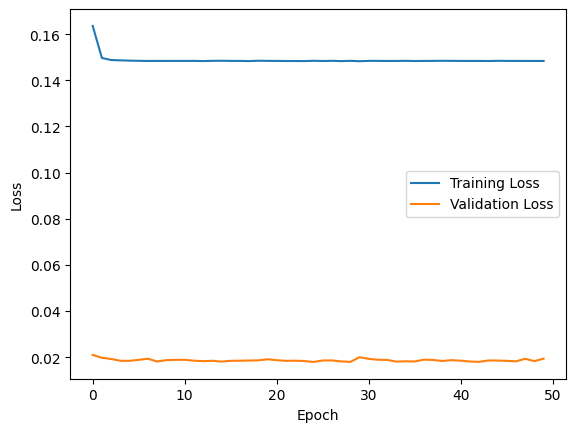

In [12]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

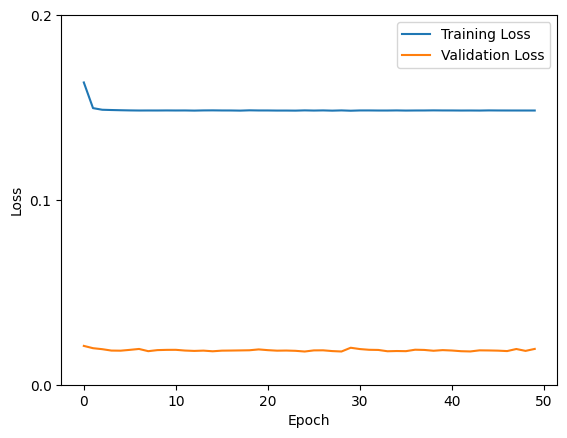

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example code assuming `history.history['loss']` and `history.history['val_loss']` are already populated
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Setting axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adjusting y-axis ticks to increments of 0.1
y_min = 0  # Set the minimum value of the y-axis as per your data
y_max = max(max(history.history['loss']), max(history.history['val_loss']))  # Get the maximum loss value
plt.yticks(np.arange(y_min, y_max + 0.1, 0.1))

# Adding legend and showing the plot
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)


Hybrid Model Accuracy: 0.8968082666305952

Precision: 0.901781066234973

Recall: 0.8968081644011837

F1-Score: 0.8958588693990077


In [15]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.10f}")

Detection Rate for Class 0: 0.9811065532
Detection Rate for Class 1: 0.6795906665
Detection Rate for Class 2: 0.8921970800
Detection Rate for Class 3: 0.9315729115
Detection Rate for Class 4: 0.9995736109


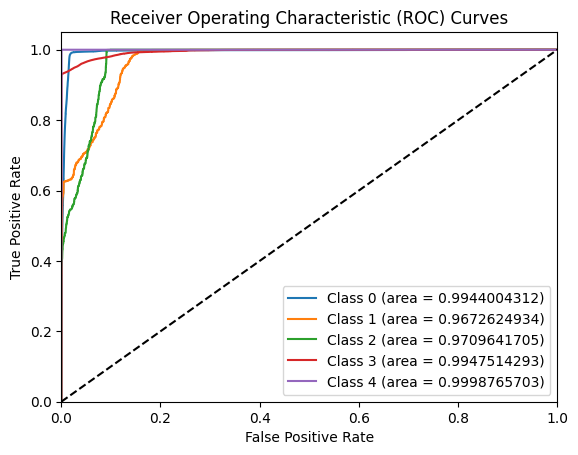

In [17]:
#Calculate ROC AUC and plot ROC curves
from sklearn.metrics import roc_curve, roc_auc_score # Import roc_curve and roc_auc_score
import matplotlib.pyplot as plt

roc_aucs = []
for i in range(5):  # Assuming 10 classes
    fpr, tpr, _ = roc_curve(y_test[:, i], test_predictions[:, i])
    roc_auc = roc_auc_score(y_test[:, i], test_predictions[:, i])
    roc_aucs.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.10f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [18]:
# Print results
#print(f"\nHybrid Model Accuracy with FGSM: {accuracy:.10f}")
#print("\nClassification Report:\n", classification_rep)
#print("\nConfusion Matrix:\n", conf_matrix)

# Print results
print(f"\nHybrid Model Accuracy with FGSM: {accuracy:.10f}")
classification_rep = classification_report(true_labels, test_predictions_labels)  # Store the classification report
print("\nClassification Report:\n", classification_rep)
# Assuming 'conf_matrix' will be calculated and assigned similarly:
conf_matrix = confusion_matrix(true_labels, test_predictions_labels)  # Store the confusion matrix
print("\nConfusion Matrix:\n", conf_matrix)


Hybrid Model Accuracy with FGSM: 0.8968082666

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     68013
           1       0.84      0.68      0.75     68013
           2       0.74      0.89      0.81     68013
           3       0.99      0.93      0.96     68014
           4       1.00      1.00      1.00     68013

    accuracy                           0.90    340066
   macro avg       0.90      0.90      0.90    340066
weighted avg       0.90      0.90      0.90    340066


Confusion Matrix:
 [[66728   991     1   202    91]
 [  145 46221 21205   442     0]
 [    0  7332 60681     0     0]
 [ 4368   284     2 63360     0]
 [   29     0     0     0 67984]]


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="bone",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.8)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  ax.yaxis.set_ticklabels(['Normal','Blackhole','Flooding','Grayhole','TDMA'])
  #plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  #plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid LR-BiLSTM Model


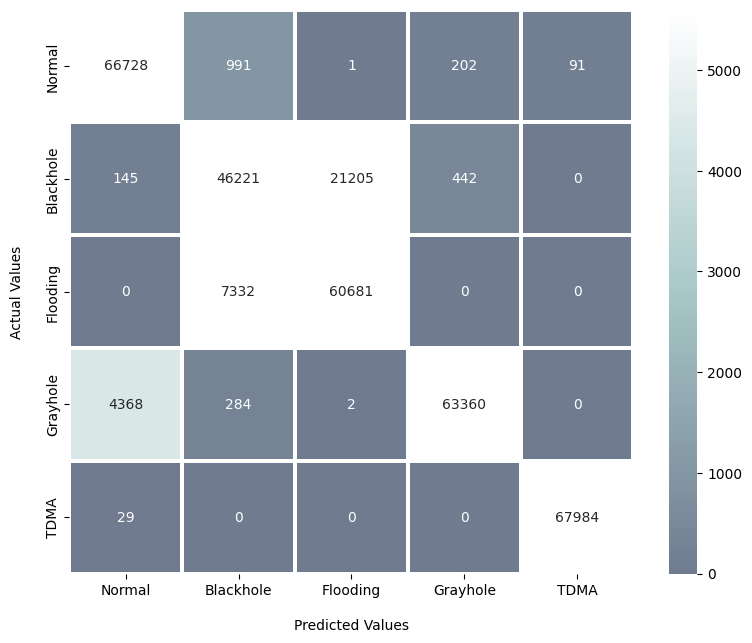

In [20]:
print("Confusion Matrix of Hybrid LR-BiLSTM Model")
conf_mat(true_labels, test_predictions_labels)

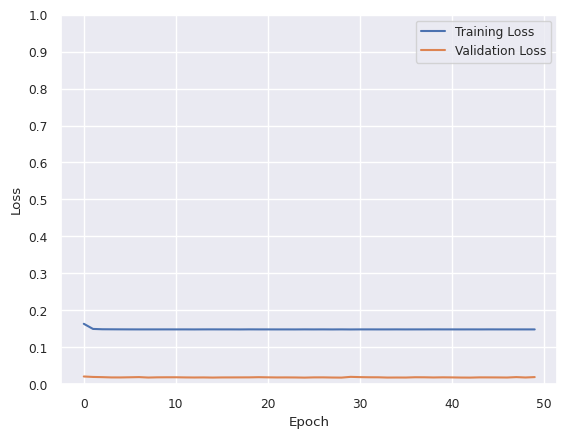

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example code assuming `history.history['loss']` and `history.history['val_loss']` are already populated
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Setting axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adjusting y-axis ticks to range from 0 to 1.0 in 0.1 increments
plt.yticks(np.arange(0, 1.1, 0.1))  # np.arange creates tick values from 0 to 1.0 (inclusive of 1.0)
plt.ylim(0, 1.0)  # Set y-axis limits to start at 0 and end at 1.0

# Adding legend and showing the plot
plt.legend()
plt.show()